In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch as tc
import torchvision as tcv
from skimage import io
import random
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import  transforms, datasets, models
from sklearn.model_selection import train_test_split


In [ ]:

! pip install vgg_pytorch

In [ ]:
! pip install torchsummary

In [ ]:


from torchsummary import summary
from vgg_pytorch import VGG 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/BIOMEDZIK/SEMESTR6/TOM/PROJEKT"
path_testing = path + "/Testingg"
path_training = path + "/Training"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_test = os.listdir(path_testing)
list_train = os.listdir(path_training)
print(list_test)
print(list_train)

['no_tumor', 'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor']
['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']


In [ ]:

#Training data 
train_glioma = path_training + "/glioma_tumor"
train_meningioma = path_training + "/meningioma_tumor"
train_no_tumour = path_training + "/no_tumor"
train_pituitary = path_training + "/pituitary_tumor"

print(len(os.listdir(train_glioma)))
print(len(os.listdir(train_meningioma)))
print(len(os.listdir(train_no_tumour)))
print(len(os.listdir(train_pituitary)))

#Testing data
test_glioma = path_testing + "/glioma_tumor"
test_meningioma = path_testing + "/meningioma_tumor"
test_no_tumour = path_testing + "/no_tumor"
test_pituitary = path_testing + "/pituitary_tumor"

print(len(os.listdir(test_glioma)))
print(len(os.listdir(test_meningioma)))
print(len(os.listdir(test_no_tumour)))
print(len(os.listdir(test_pituitary)))

826
822
395
837
100
115
105
74


In [ ]:
class TumorCTDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

def encode_class(filename, main_path):
    if filename[len(path_training)+1] == "g":
        label = 0
    elif filename[len(path_training)+1] == "m":
        label = 1
    elif filename[len(path_training)+1] == "n":
        label = 2
    else:
        label = 3
    return label

classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


In [ ]:
paths_to_notumor_imgs = [path_training + '/' + "no_tumor" + '/' + img for img in os.listdir(path_training + '/' + "no_tumor")]
paths_to_pituitary_imgs = [path_testing + '/' + "pituitary_tumor" + '/' + img for img in os.listdir(path_testing + '/' + "pituitary_tumor")]
paths_to_pituitary_imgs= paths_to_pituitary_imgs[0:36]

paths_to_training_imgs = [path_training + '/' + element + '/' + img for element in os.listdir(path_training) for img in os.listdir(path_training + '/' + element)]
paths_to_testing_imgs = [path_testing + '/' + element + '/' + img for element in os.listdir(path_testing) for img in os.listdir(path_testing + '/' + element)]

random.shuffle(paths_to_training_imgs) 
random.shuffle(paths_to_testing_imgs) 
print(len(paths_to_training_imgs))
print(len(paths_to_testing_imgs))

transform_aug = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize((224,224)),
                            transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.8),
                            transforms.RandomRotation(30),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                            ])


transform = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize((224,224)),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                               ])

2880
394


In [ ]:
label_img_train = [encode_class(path, path_training) for path in paths_to_training_imgs]
label_img_test = [encode_class(path, path_testing) for path in paths_to_testing_imgs]
label_augmentation_pituitary = [encode_class(path, path_testing) for path in paths_to_pituitary_imgs]
label_augmentation_notumor = [encode_class(path, path_training) for path in paths_to_notumor_imgs]

print("Testing")
print(len(label_img_train))
print(len(label_augmentation_notumor))
print("Testing:")
print(len(label_img_test))
print(len(label_augmentation_pituitary))


Testing
2880
395
Testing:
394
36


In [ ]:
paths_to_validation_imgs = paths_to_training_imgs [0:430]
paths_to_training_imgs = paths_to_training_imgs [430::]
print(len(paths_to_validation_imgs))
print(len(paths_to_training_imgs))
label_img_val = [encode_class(path, path_training) for path in paths_to_validation_imgs]
print(len(label_img_val))

430
2450
430


In [ ]:
batch_size = 4
num_workers = 2

all_train__dataset = TumorCTDataset(paths_to_training_imgs,label_img_train, transforms=transform)
all_test__dataset = TumorCTDataset(paths_to_testing_imgs,label_img_test, transforms=transform)
all_val__dataset = TumorCTDataset(paths_to_validation_imgs,label_img_val, transforms=transform)

aug_test__pit = TumorCTDataset(paths_to_pituitary_imgs,label_augmentation_pituitary, transforms=transform_aug )
aug_train__not = TumorCTDataset(paths_to_notumor_imgs,label_augmentation_notumor, transforms=transform_aug )
all_test__dataset+=aug_test__pit
all_train__dataset+=aug_train__not


print("After augmentation: Train-2845, Test=Val - 430, All - 3705")
all= len(paths_to_training_imgs) + len(paths_to_notumor_imgs) + len(paths_to_pituitary_imgs) + len(paths_to_testing_imgs) + len(paths_to_validation_imgs)


print(f"Percent of training data {round( 100*len(all_train__dataset)/all)}%.")
print(f"Percent of test data {round(100*len(all_test__dataset)/all)}%.")
print(f"Percent of test data {round(100*len(all_val__dataset)/all)}%.")

all_train_loader = DataLoader(all_train__dataset, batch_size=batch_size,  shuffle=True)
all_test_loader = DataLoader(all_test__dataset, batch_size=batch_size,  shuffle=True)
all_val_loader = DataLoader(all_val__dataset, batch_size=batch_size,  shuffle=True)

After augmentation: Train-2845, Test=Val - 430, All - 3705
Percent of training data 77%.
Percent of test data 12%.
Percent of test data 12%.


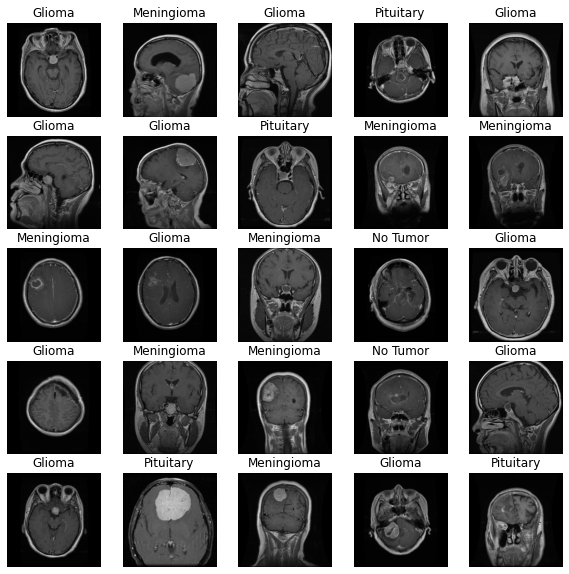

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(io.imread(paths_to_training_imgs[i]), cmap='gray')
    plt.axis('off')
    plt.title("Przykłądowe zdjecia ze zbioru treningowego")
    plt.title(classes[label_img_train[i]])
plt.show()

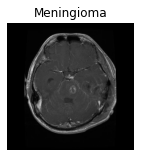

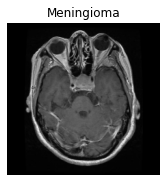

In [ ]:
for image, label in all_train_loader:
    plt.figure(figsize=(5,5))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(image[i, :, :, :].permute(1, 2, 0).numpy()[...,0], cmap='gray')
        plt.axis('off')
        plt.title(classes[label[i]])
        plt.show()
    break

In [ ]:
model = VGG.from_pretrained('vgg16', num_classes=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(summary(model, input_size=(3, 224, 224)))

Loaded pretrained weights for vgg16
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
   

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate=0.0075
optimizer = tc.optim.RMSprop(model.parameters(), lr=learning_rate)
epochs = 10

In [ ]:
training_size = len(all_train_loader.dataset)
testing_size = len(all_val_loader.dataset)

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]

num_epochs = 10

for epoch in range(num_epochs):
  print('Epoch: %.3f'%(epoch+1))
  running_loss = 0.0
  correct=0
  total=0
  running_val_loss = 0.0
  correct_val=0
  total_val=0  
  model.train()
  for images, labels in tqdm.tqdm(all_train_loader, position=0, leave=True):
    
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    results = model(images)
    loss = loss_fn(results, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = results.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    
  train_loss=running_loss/len(all_train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


  model.eval()
  with torch.no_grad():
    for images, labels in tqdm.tqdm(all_val_loader, position=0, leave=True):
      
      images = images.to(device)
      labels = labels.to(device)

      results = model(images)
      val_loss = loss_fn(results, labels)

      running_val_loss += val_loss.item()
      _, predicted_val = results.max(1)
      total_val += labels.size(0)
      correct_val += predicted_val.eq(labels).sum().item()

  test_loss=running_val_loss/len(all_val_loader)
  accu_val=100.*correct_val/total_val

  eval_losses.append(test_loss)
  eval_accu.append(accu_val)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu_val))

In [ ]:

plt.figure()
plt.plot(loss_history, "r-")
plt.plot(val_loss_history, "g-")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training set','Validation set'])
plt.show()
#plt.savefig('loss.png')

plt.figure()
plt.plot(accuracy_history_train, "r-")
plt.plot(accuracy_history_test,"g-")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training set','Validation set'])
plt.show()
#plt.savefig('accuracy.png')

In [ ]:

test_iterator = iter(all_test_loader)
images, labels = test_iterator.next()
images, labels = images.cuda(), labels.cuda()

results = model(images)
_, predicted = tc.max(results, 1)

rows = 2
columns = 2

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure(dpi=100)
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title(f'truth  {classes[labels[i].int()]} : predict  {classes[predicted[i]]}')
   plt.tight_layout()
   img = images[i] / 2 + 0.5     
   img =  img.permute(1, 2, 0)[...,0]
   img = tcv.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = np.arange(0)
predicted_labels = np.arange(0)

for i in range(107): 
  test_iterator = iter(all_test_loader)
  images, labels = test_iterator.next()
  images, labels = images.cuda(), labels.cuda()

  results = model(images)
  _, predicted = tc.max(results, 1)

  labels = labels.cpu().numpy()
  predicted = predicted.cpu().numpy()
  
  true_labels = np.append(true_labels, labels)
  predicted_labels = np.append(predicted_labels,predicted)

cm=confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix : ")
print(cm)



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)

In [ ]:
accuracy = np.trace(cm) /430 * 100
print(f"Accuracy: {accuracy}%")